# Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,BatchNormalization,Dropout ,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import Input, Model


# EDA Of Data

In [3]:
data_dir = '/kaggle/input/eurosat-dataset/EuroSAT'
filepaths = []
labels = []

# List only directories (classes)
folds = [f for f in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, f))]

for fold in folds:
    foldpath = os.path.join(data_dir, fold)
    files = os.listdir(foldpath)
    for file in files:
        filepath = os.path.join(foldpath, file)
        filepaths.append(filepath)
        labels.append(fold)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})
df.head()

,filepaths,labels
0,/kaggle/input/eurosat-dataset/EuroSAT/SeaLake/...,SeaLake
1,/kaggle/input/eurosat-dataset/EuroSAT/SeaLake/...,SeaLake
2,/kaggle/input/eurosat-dataset/EuroSAT/SeaLake/...,SeaLake
3,/kaggle/input/eurosat-dataset/EuroSAT/SeaLake/...,SeaLake
4,/kaggle/input/eurosat-dataset/EuroSAT/SeaLake/...,SeaLake


In [4]:
train_df,test_df=train_test_split(df,test_size=.2,random_state=42)


In [5]:
print('Number of classes :',train_df['labels'].nunique())
class_names=sorted(train_df['labels'].unique())
for indx,name in enumerate(class_names):
    print(indx,'->',name)

Number of classes : 10
0 -> AnnualCrop
1 -> Forest
2 -> HerbaceousVegetation
3 -> Highway
4 -> Industrial
5 -> Pasture
6 -> PermanentCrop
7 -> Residential
8 -> River
9 -> SeaLake


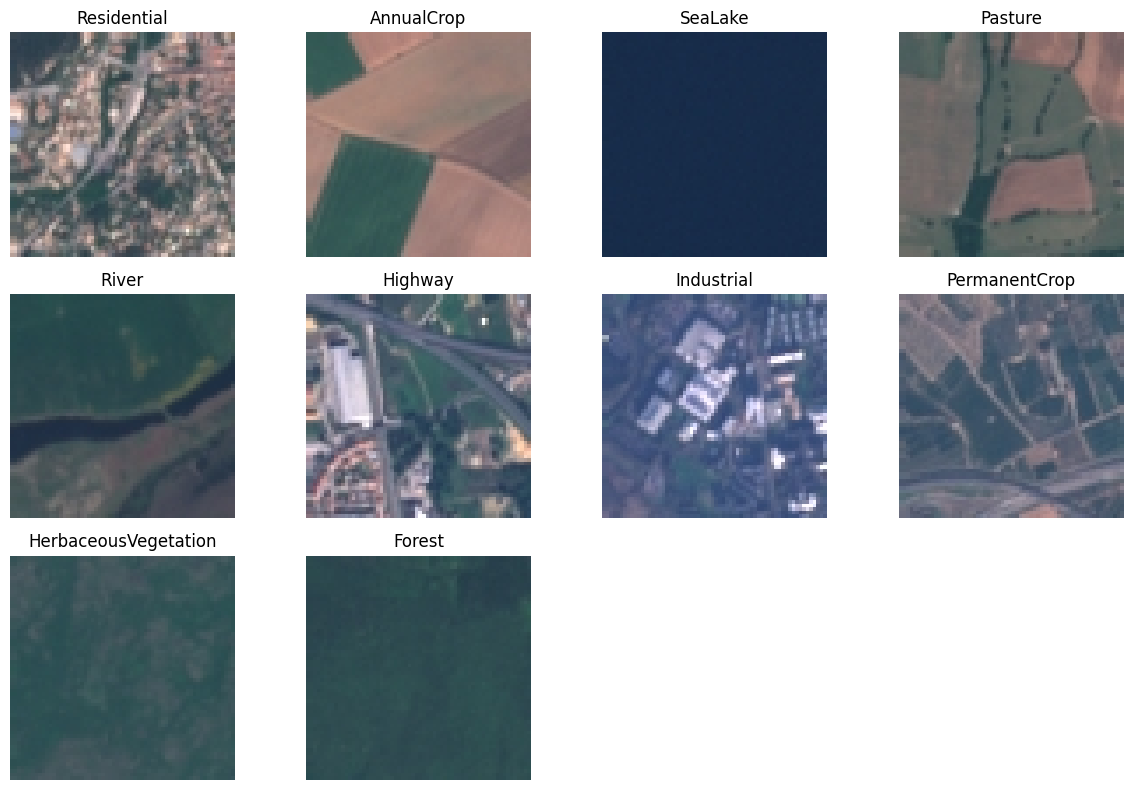

In [6]:
classes = train_df['labels'].unique()

plt.figure(figsize=(12, 8))
for i, cls in enumerate(classes):
    sample = train_df[train_df['labels'] == cls].iloc[0]
    img = Image.open(sample['filepaths'])

    plt.subplot(3, 4, i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis("off")

plt.tight_layout()
plt.show()


# Data Augmentation

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)

val_datagen = ImageDataGenerator(
    rescale=1/255.0
)

In [8]:

train_gen=train_datagen.flow_from_dataframe(train_df,color_mode='rgb',x_col='filepaths',y_col='labels',target_size=(224,224)
                                  ,class_mode='categorical',batch_size=16,shuffle=True)

Found 21600 validated image filenames belonging to 10 classes.


In [9]:

val_gen=val_datagen.flow_from_dataframe(test_df,color_mode='rgb',x_col='filepaths',y_col='labels',target_size=(224,224)
                                  ,class_mode='categorical',batch_size=16,shuffle=False)

Found 5400 validated image filenames belonging to 10 classes.


# Building Model

In [10]:
from tensorflow.keras import Input, Model
base_model = tf.keras.applications.EfficientNetB3(include_top=False,input_shape=(224, 224, 3))

base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

# Functional API
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
outputs = Dense(10, activation='softmax')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


I0000 00:00:1764256633.941297      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb3 (Functional)     │ (None, 7, 7, 1536)     │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       786,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,704,377 (44.65 MB)

 Trainable params: 11,591,892 (44.22 MB)

 Non-trainable params: 112,485 (439.40 KB)

# Train Model

In [11]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1764256702.183757     110 service.cc:148] XLA service 0x7832d8003cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764256702.184455     110 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764256709.433850     110 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1764256719.404246     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764256719.597344     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764256720.070854     110 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764256720.2876

   1/1350 ━━━━━━━━━━━━━━━━━━━━ 35:06:45 94s/step - accuracy: 0.0625 - loss: 2.3445

I0000 00:00:1764256746.943617     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 405s 230ms/step - accuracy: 0.3771 - loss: 1.8019 - val_accuracy: 0.8009 - val_loss: 0.6626
Epoch 2/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 242s 179ms/step - accuracy: 0.7190 - loss: 0.8353 - val_accuracy: 0.8978 - val_loss: 0.3206
Epoch 3/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 240s 178ms/step - accuracy: 0.8092 - loss: 0.5727 - val_accuracy: 0.9189 - val_loss: 0.2390
Epoch 4/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 243s 180ms/step - accuracy: 0.8466 - loss: 0.4586 - val_accuracy: 0.9263 - val_loss: 0.2131
Epoch 5/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 243s 180ms/step - accuracy: 0.8655 - loss: 0.3964 - val_accuracy: 0.9404 - val_loss: 0.1770
Epoch 6/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 252s 187ms/step - accuracy: 0.8866 - loss: 0.3441 - val_accuracy: 0.9381 - val_loss: 0.1751
Epoch 7/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 251s 186ms/step - accuracy: 0.8889 - loss: 0.3282 - val_accuracy: 0.9500 - val_loss: 0.1435
Epoch 8/15
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 254s 188ms/step - accuracy: 0.8

In [13]:
model.evaluate(train_gen)

1350/1350 ━━━━━━━━━━━━━━━━━━━━ 256s 190ms/step - accuracy: 0.9769 - loss: 0.0680


[0.0706283301115036, 0.976111114025116]

In [14]:
model.evaluate(val_gen)

338/338 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.9664 - loss: 0.0938


[0.09290139377117157, 0.9670370221138]

# Evaluate Model

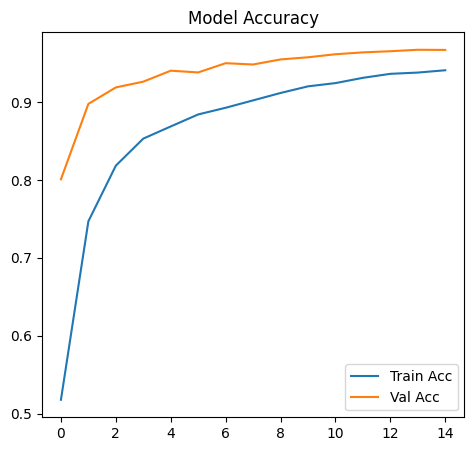

In [15]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()

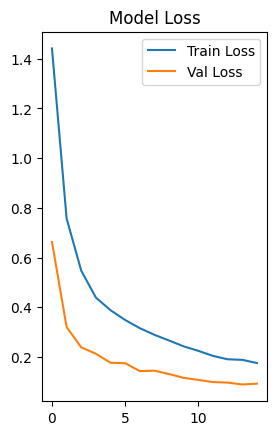

In [16]:
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

In [17]:
y_true = val_gen.classes
y_pred = np.argmax(model.predict(val_gen), axis=1)
labels = list(val_gen.class_indices.keys())

338/338 ━━━━━━━━━━━━━━━━━━━━ 28s 57ms/step


In [18]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=labels))


Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.98      0.95      0.96       587
              Forest       0.96      0.99      0.98       594
HerbaceousVegetation       0.96      0.94      0.95       606
             Highway       0.98      0.97      0.98       499
          Industrial       0.99      0.95      0.97       514
             Pasture       0.95      0.97      0.96       407
       PermanentCrop       0.93      0.93      0.93       482
         Residential       0.95      1.00      0.97       614
               River       0.96      0.98      0.97       502
             SeaLake       0.99      0.98      0.99       595

            accuracy                           0.97      5400
           macro avg       0.97      0.97      0.97      5400
        weighted avg       0.97      0.97      0.97      5400



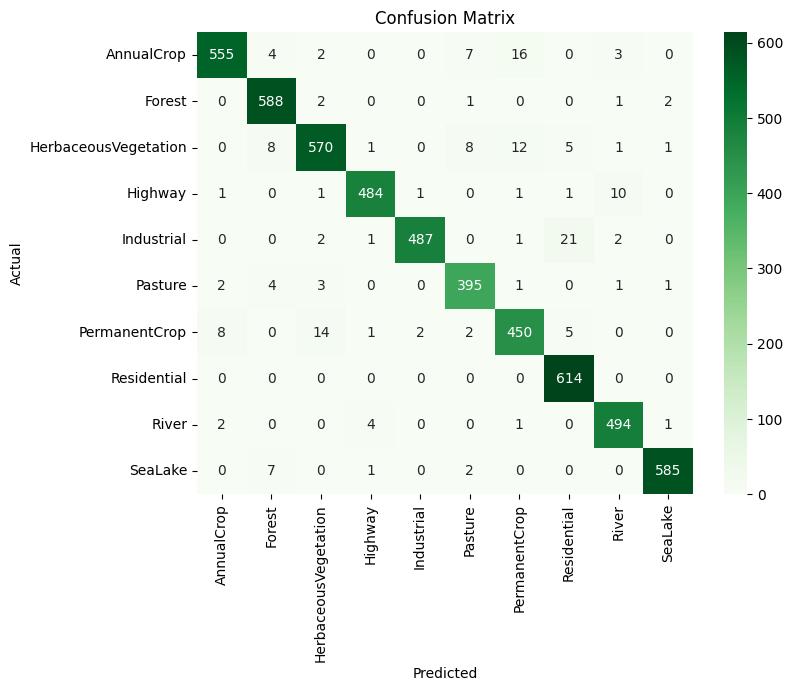

In [19]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [71]:
keras_model=model.save("efficient_model_96.keras")   # SavedModel format


# Predicting Random Images

In [88]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np

# تأكد إن المسار صحيح وصيغة الموديل مظبوطة
keras_model = tf.keras.models.load_model("/kaggle/working/efficient_model_96.keras")  

classes = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", 
           "Industrial", "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"]

def predict_image(model, img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_arr = image.img_to_array(img)
    img_arr = img_arr / 255.0
    img_arr = np.expand_dims(img_arr, axis=0)

    preds = model.predict(img_arr)
    class_id = np.argmax(preds)
    confidence = preds[0][class_id]

    print(f"\nTop Prediction: {classes[class_id]}  ({confidence*100:.2f}%)")

    top3 = preds[0].argsort()[-3:][::-1]
    print("\nTop 3 classes:")
    for i in top3:
        print(f"{classes[i]}: {preds[0][i]*100:.2f}%")

    return class_id

predict_image(keras_model, "/kaggle/input/eurosat-dataset/EuroSAT/River/River_1002.jpg")


1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step

Top Prediction: River  (100.00%)

Top 3 classes:
River: 100.00%
Highway: 0.00%
Pasture: 0.00%


8